In [2]:
pwd

'/home/jovyan/critical_feature_extraction/ipynb'

In [3]:
cd ..

/home/jovyan/critical_feature_extraction


In [4]:
%run __init__.py
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Clean Data:
1. Download 3 stocks' TI's
2. Check data
3. Drop unnessesary columns
4. concatenate the data

In [11]:
apple = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/AAPL_data.csv')

abbvie = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/ABBV_data.csv')

cvs = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/CVS_data.csv')

wfc = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/WFC_data.csv')

In [6]:
def clean_data(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    else:
        pass
    if 'Unnamed: 0.1' in df.columns:    
        df = df.drop('Unnamed: 0.1', axis=1)
    else:
        pass
    if 'Unnamed: 0.1.1' in df.columns:
        df = df.drop('Unnamed: 0.1.1', axis=1)
    else:
        pass
    return df

In [7]:
apple = clean_data(apple)
cvs = clean_data(cvs)
wfc= clean_data(wfc)
abbvie = clean_data(abbvie)

In [8]:
cvs.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name', 'ADX_14_50',
       'ATR_14', 'BollingerB_5', 'Bollinger%b_5', 'BollingerB_20',
       'Bollinger%b_20', 'Copp_10', 'Chaikin', 'EMA_5', 'EMA_20', 'Force_2',
       'KST_10_10_10_15_10_15_20_30', 'MA_5', 'MA_20', 'MACD_12_26',
       'MACDsign_12_26', 'MACDdiff_12_26', 'MFI_14', 'Momentum_1',
       'Mass Index', 'OBV_5', 'OBV_20', 'PP', 'R1', 'R2', 'R3', 'S1', 'S2',
       'S3', 'ROC_5', 'ROC_20', 'RSI_6', 'RSI_12', 'STD_5', 'STD_20', 'SO%d_5',
       'SO%d_20', 'SO%k', 'Trix_5', 'Trix_20', 'TSI_25_13', 'Target'],
      dtype='object')

In [174]:
multi_positions = pd.concat([wfc, cvs], axis=1, join='inner')
multi_positions = pd.concat([multi_positions, apple], axis = 1, join='inner')
multi_positions = pd.concat([multi_positions, abbvie], axis=1, join='inner')

In [175]:
multi_positions = multi_positions.set_index(pd.to_datetime(multi_positions.Date))
multi_positions = multi_positions.drop('Date', axis=1)
multi_positions = pd.get_dummies(multi_positions)
multi_positions = multi_positions.sort_index()

In [176]:
multi_positions.shape 

(4677, 51)

### Benchmarking with naive PCA and Linear Regression:
1. Prepare data for pipeline
2. Create a pipeline with:
    - Standardization
    - PCA
    - Linear Regression
3. Fit model
4. Produce scores
5. Visualize the Principal components

In [177]:
#define the y's as the current day's trading signal (because we shift the data in the next step we have to drop the first day)
y = multi_positions.Target
#we shift the current days features to the previous days, so we can predict tomorrow's trading signal
# multi_positions = multi_positions.iloc[:, :46].shift()
#drop the NAN values created by the shift
# multi_positions = multi_positions.dropna()
# define X's as the features without the targets
X = multi_positions.drop('Target', axis=1)

In [178]:
#because this is time-series data we must manually split the data 
X_train = X.iloc[0:3508, :]
y_train = y.iloc[0:3508]
X_test = X.iloc[3508:, :]
y_test = y.iloc[3508:]

In [179]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('linreg', LinearRegression())
])

In [180]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [181]:
y_pred = pipeline.predict(X_test)

In [182]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Explain Variance: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.12
Explain Variance: -0.19


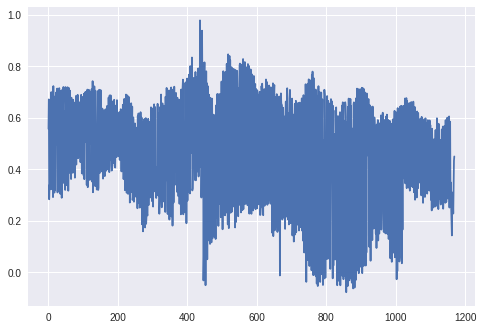

In [183]:
plt.plot(y_pred)
plt.show()

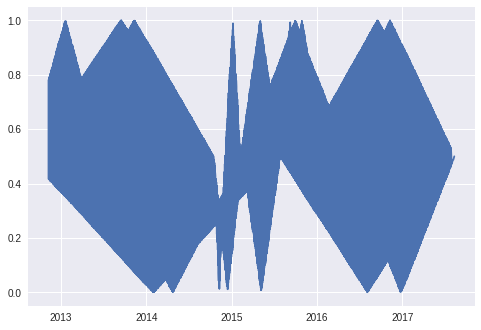

In [184]:
plt.plot(y)
plt.show()